In [16]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from gpflow.test_util import notebook_niter

from sklearn.model_selection import train_test_split

np.random.seed(0)

In [38]:
colors = [
    [.8,.0,.0,1.0],
    [.0,.8,.0,1.0],
    [.0,.0,.8,1.0],
    [.8,.8,.0,1.0],
    [.0,.8,.8,1.0],
    [.8,.0,.8,1.0]
]


def plot_posterior_predictions(m, X_test, y_test):
    fig = plt.figure(figsize=(10,4))
    a1 = fig.add_axes([0.05, 0.05, 0.9, 0.5])
    a2 = fig.add_axes([0.05, 0.65, 0.9, 0.15])
    

    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    p, _ = m.predict_y(xx)
    
    
    for c in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten()==c]
        
        color=colors[c]
        a1.plot(xx, mu[:,c], color=color, lw=2, label='%d'%c)
        a1.plot(xx, mu[:,c] + 2*np.sqrt(var[:,c]), '--', color=color)
        a1.plot(xx, mu[:,c] - 2*np.sqrt(var[:,c]), '--', color=color)
        a2.plot(xx, p[:,c], '-', color=color, lw=2)

        
    a2.scatter(X_test, np.ones(len(X_test))+0.2, color=[colors[c] for c in y_test], s=2)
    
    a2.set_ylim(-0.1, 1.4)
    a2.set_yticks([0, 1])
    a2.set_xticks([])
    
    a2.set_title('Test samples & predicted means')
    a1.set_title('Posterior latent functions and confidence regions')
    
    handles, labels = a1.get_legend_handles_labels()
    a1.legend(handles, labels, loc='lower right')
    fig.tight_layout()
    plt.show()


# 1D Mulitclass on synthetic data

Based on tutorial by GPFlow but with more classes

In [18]:
# Number of functions and number of data points
C = 6
N = 500
D = 1

# RBF kernel lengthscale
lengthscale = 0.1

# Jitter
jitter_eye = np.eye(N) * 1e-6

# Input
np.random.seed(12)
X = np.random.uniform(0,1,N).reshape(-1,1)

In [19]:
# RBF kernel matrix
np.random.seed(12)
kern = gpflow.kernels.RBF(D, lengthscales=lengthscale)
K = kern.compute_K_symm(X) + jitter_eye

# Latents prior sample
f = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T

# Hard max observation
Y = np.argmax(f, 1).reshape(-1,).astype(int)

# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=100,stratify=Y,random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
print('Input shape: %s, Output shape: %s' % (X_train.shape, y_train.shape))

Train: 100, Test: 400
Input shape: (100, 1), Output shape: (100,)


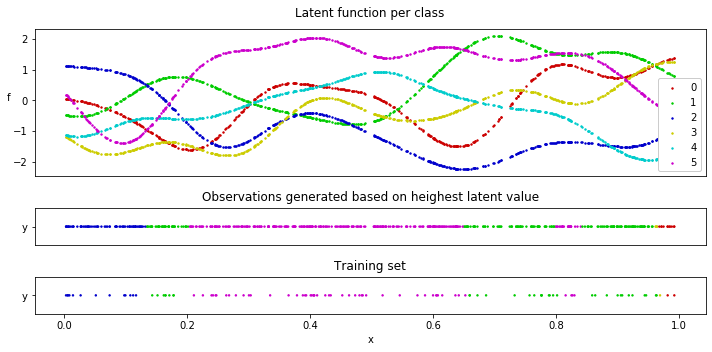

In [21]:
fig,ax = plt.subplots(3,1,figsize=(10,5), gridspec_kw={'height_ratios': [4,1,1]})
for i in range(f.shape[1]):
    ax[0].scatter(X, f[:,i], color=colors[i], s=2, label='%d'%i);
ax[0].set_ylabel('f', rotation=0)
ax[0].set_title('Latent function per class', y=1.04);
ax[0].set_xticks([])

ax[1].set_title('Observations generated based on heighest latent value', y=1.04);
ax[1].scatter(X, np.ones(N), color=[colors[c] for c in Y], s=2)
ax[1].set_yticks([1])
ax[1].set_yticklabels(['y'])
ax[1].set_xticks([])

ax[2].set_title('Training set', y=1.04);
ax[2].scatter(X_train, np.ones(100), color=[colors[c] for c in y_train], s=2)
ax[2].set_yticks([1])
ax[2].set_yticklabels(['y'])
ax[2].set_xlabel('x')
ax[0].legend(loc='lower right', framealpha=1)

fig.tight_layout()

## MultiClass Likelihood with RobustMax-Inverse-Link

In [43]:
# sum kernel: Matern32 + White
kern = gpflow.kernels.Matern32(D) + gpflow.kernels.White(D, variance=0.01)

# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C, epsilon=1e-9)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(C, invlink=invlink)  # Multiclass likelihood
Z = X_train[::1].copy()  # inducing inputs

m = gpflow.models.SVGP(
    X_train, y_train, kern=kern, likelihood=likelihood,
    Z=Z, num_latent=C, whiten=True, q_diag=True)

# Only train the variational parameters
m.kern.kernels[1].variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),False,"(100, 1)",True,"[[0.4332931367915722], [0.8250092532147735], [..."
SVGP/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/kernels/1/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/likelihood/invlink/epsilon,Parameter,"Beta(0.2,5.0)","[0.0, 1.0]",False,(),True,1e-09
SVGP/q_mu,Parameter,None,(none),True,"(100, 6)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(100, 6)",True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1...."


In [44]:
opt = gpflow.train.ScipyOptimizer(options={'maxls': 30,'ftol':1e-10, 'disp':False})
opt.minimize(m, maxiter=notebook_niter(1000))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.534433
  Number of iterations: 457
  Number of functions evaluations: 506


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 121.534433
  Number of iterations: 457
  Number of functions evaluations: 506


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


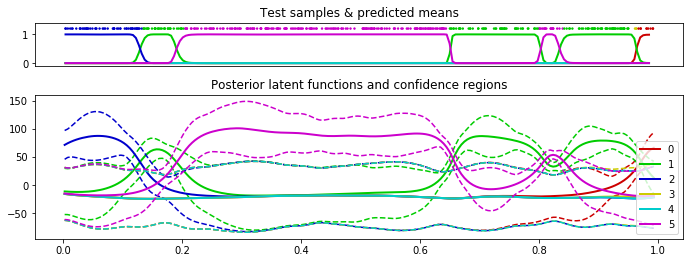

In [45]:
plot_posterior_predictions(m, X_test, y_test)

In [46]:
p = m.predict_y(X_test)
pred = np.argmax(p[0], axis=1)
np.equal(pred, y_test).mean()

0.9625

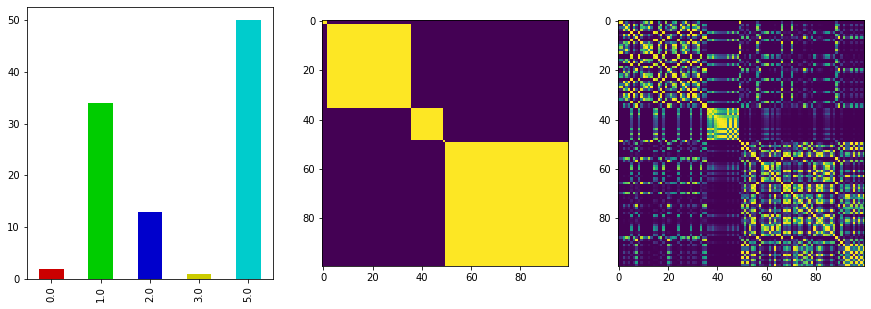

In [14]:
# sort them by class and show covariance
df = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)).sort_values(by=1)
inputs = df[0].values.reshape(-1,1)
outputs = df[1].values.reshape(-1,1)
fig, ax = plt.subplots(1,3, figsize=(15,5))
df[1].value_counts().sort_index().plot(kind='bar', ax=ax[0], color=colors)
ax[1].imshow(kern.compute_K_symm(outputs))
ax[2].imshow(kern.compute_K_symm(inputs));

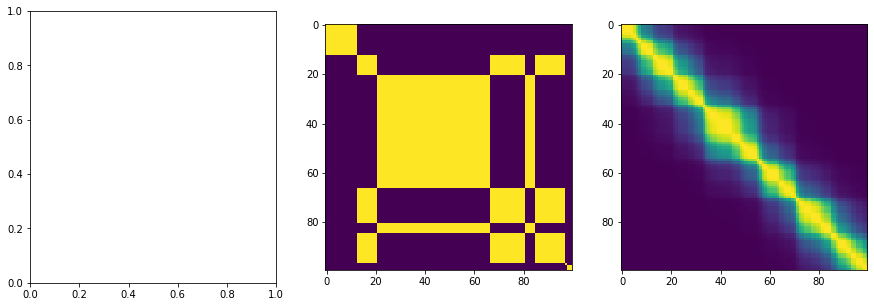

In [15]:
# now sort them by input an show covariance
df = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)).sort_values(by=0)
inputs = df[0].values.reshape(-1,1)
outputs = df[1].values.reshape(-1,1)
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[1].imshow(kern.compute_K_symm(outputs))
ax[2].imshow(kern.compute_K_symm(inputs));

# 2D Mulitclass on synthetic data

Use 2D inputs

In [3]:
# Number of functions (classes) and number of data points
C = 6
N = 1000
D = 2

np.random.seed(23)

# RBF kernel lengthscale
lengthscale = 0.2

# Jitter
jitter_eye = np.eye(N) * 1e-6

# Input
X = np.random.rand(N, D)

# RBF kernel matrix
kern = gpflow.kernels.RBF(D, lengthscales=lengthscale)
K = kern.compute_K_symm(X) + jitter_eye

# Latents prior sample
f = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T
# Hard max observation
Y = np.argmax(f, 1).reshape(-1,).astype(int)

# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=200, stratify=Y, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
print('Input shape: %s, Output shape: %s' % (X_train.shape, y_train.shape))

Train: 200, Test: 800
Input shape: (200, 2), Output shape: (200,)


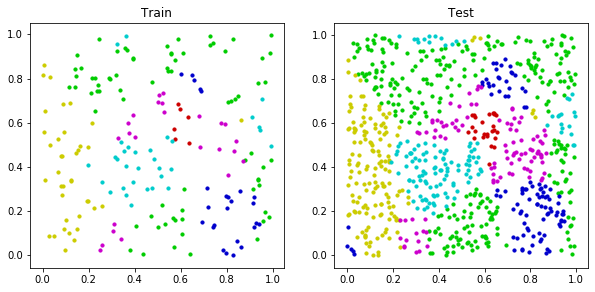

In [5]:
fig, ax = plt.subplots(1,2,figsize=(10,4.5))
[ax[0].scatter(X_train[y_train==i, 0], X_train[y_train==i, 1], c=[colors[i]], s=10) for i in range(C)];
[ax[1].scatter(X_test[y_test==i, 0], X_test[y_test==i, 1], c=[colors[i]], s=10) for i in range(C)];
ax[0].set_title('Train')
ax[1].set_title('Test');

In [6]:
# sum kernel: Matern32 + White
kern = gpflow.kernels.Matern32(D) #+ gpflow.kernels.White(D, variance=0.01)

# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(C, invlink=invlink)  # Multiclass likelihood
Z = X_train[::1].copy()  # inducing inputs

m = gpflow.models.VGP(
    X_train, y_train, kern=kern, likelihood=likelihood,
     num_latent=C)

# Only train the variational parameters
m.kern.variance.trainable = True
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
VGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
VGP/likelihood/invlink/epsilon,Parameter,"Beta(0.2,5.0)","[0.0, 1.0]",False,(),True,0.001
VGP/q_mu,Parameter,None,(none),True,"(200, 6)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(6, 200, 200)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [7]:
opt = gpflow.train.ScipyOptimizer(options={'maxls': 30,'ftol':1e-10, 'disp':False})
opt.minimize(m, maxiter=notebook_niter(1000))
m

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 196.294071
  Number of iterations: 509
  Number of functions evaluations: 546


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 196.294071
  Number of iterations: 509
  Number of functions evaluations: 546


,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/lengthscales,Parameter,None,+ve,True,(),True,0.3900290993985014
VGP/kern/variance,Parameter,None,+ve,True,(),True,1.0011052835676204
VGP/likelihood/invlink/epsilon,Parameter,"Beta(0.2,5.0)","[0.0, 1.0]",False,(),True,0.001
VGP/q_mu,Parameter,None,(none),True,"(200, 6)",True,"[[-0.30531077215601005, 0.77539812814674, 0.14..."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(6, 200, 200)",True,"[[[-0.3241225321372191, 0.0, 0.0, 0.0, 0.0, 0...."


### Predict

In [11]:
# threshold for prediction. Only use prediction if confidence for maximum class is > threshold 
threshold = 0.9

p = m.predict_y(X_test)
pred = np.argmax(p[0], axis=1)
pred_conf = np.max(p[0], axis=1)

# Score
np.equal(pred[pred_conf > threshold], y_test[pred_conf > threshold]).mean()

0.9584664536741214

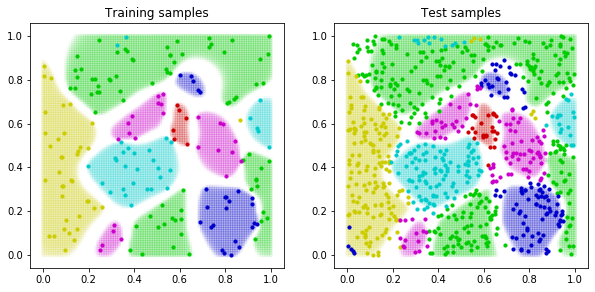

In [12]:
# Plot results
x_grid = np.linspace(0, 1, 100)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(),yy.flatten())).T
p, _ = m.predict_y(Xplot)
pred=np.argmax(p, axis=1)
pred_conf=np.max(p, axis=1)
rgba_colors = np.zeros((Xplot.shape[0],4))
for i in range(C):
    rgba_colors[pred==i,:] = colors[i]
rgba_colors[:,3] = ((pred_conf-threshold)/(1-threshold)) *0.15 * (pred_conf > threshold)
fig,ax = plt.subplots(1,2, figsize=(10,4.5))
[ax[0].scatter(xx.flatten()[pred==i], yy.flatten()[pred==i], marker='o', c=rgba_colors[pred==i], s=10)  for i in range(C)];
[ax[1].scatter(xx.flatten()[pred==i], yy.flatten()[pred==i], marker='o', c=rgba_colors[pred==i], s=10)  for i in range(C)];
[ax[0].scatter(X_train[y_train==i, 0], X_train[y_train==i, 1], c=[colors[i]], s=10) for i in range(C)];
[ax[1].scatter(X_test[y_test==i, 0], X_test[y_test==i, 1], c=[colors[i]], s=10) for i in range(C)];
#_fig.suptitle('Confidence regions with training/test points overlayed (white background means confidence is below threshold)')
ax[0].set_title('Training samples')
ax[1].set_title('Test samples');

The reason there are still some training points missclassified is because of the _Robust_ Max Likelyhood, which has an _epsilon_ param to be less prone to outliers. Driving _epsilon_ to 0 should - in theory - prevent this. However in this case this fixes only the two missclassified cyan points top-left. Single outliers are not fixed. This might be a numerical issue...

This is also not an edge case. For example look at the yellow missclassified point at ~(0.85, 0.60) we can see that the model predicts class cyan with high confidence. Its not that its a thight decison between cyan and yellow, the model treats this point as an outlier explicitely. It gives some probabilites for cyan, green and purple but close to zero for the true class yellow.

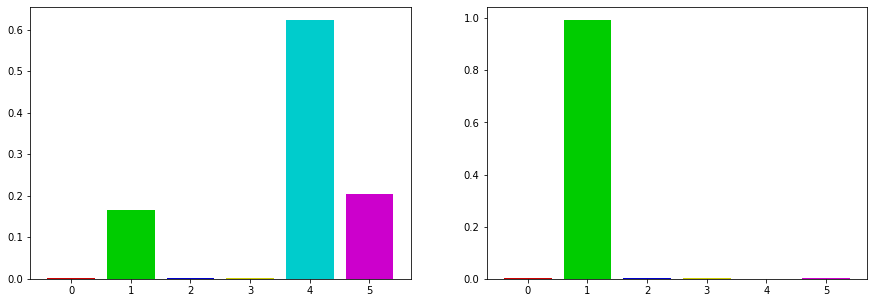

In [325]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
# print predictions for single missclassified point at (0.85, 0.60)
point_input = X_train[(X_train[:,0] < 0.9) & (X_train[:,1] < 0.7) & (X_train[:,0] > 0.8) & (X_train[:,1] > 0.55) & (y_train == 3)]
p, _ = m.predict_y(point_input)
ax[0].bar([0,1,2,3,4,5],p[0], color=colors);

# print predictions for group of missclassified points at (0.4, 1.0)
point_input = X_train[(X_train[:,0] < 0.4) & (X_train[:,1] < 1.0) & (X_train[:,0] > 0.3) & (X_train[:,1] > 0.9) & (y_train == 4)]
p, _ = m.predict_y(point_input)
ax[1].bar([0,1,2,3,4,5],p[1], color=colors);

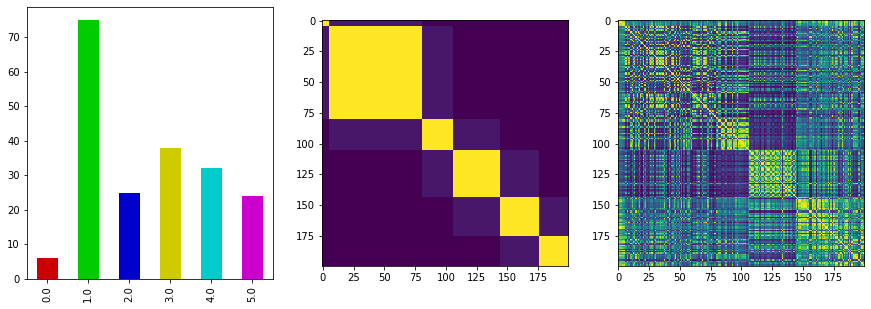

In [326]:
df = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)).sort_values(by=2)
inputs = df.loc[:,0:1].values
outputs = df.loc[:,2].values
fig, ax = plt.subplots(1,3, figsize=(15,5))
df[2].value_counts().sort_index().plot(kind='bar', ax=ax[0], color=colors)
ax[1].imshow(kern.compute_K_symm(np.stack([outputs, np.zeros(outputs.shape[0])], axis=1)))
ax[2].imshow(kern.compute_K_symm(inputs));